In [2]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

pi = np.math.pi
%matplotlib inline
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['lines.linewidth'] = 3

# Aufgabe 1: PAM (Wiederholung)
Die Datenquelle liefert einen redundanzfreien Bitstrom $\{b_n\}$ mit der Rate $1/T_b = 10\text{kbit/s}$. Das Sendefilter hat ein Root-Raised-Cosine Charakteristik mit 100% Excessbandbreite. Zunächst sei $b(t) = \delta(t)$ und das Rauschen $n(t)$ habe die spektrale Leistungsdichte von $\frac{N_0}{2}=10^{-6}\frac{1}{\text{Hz}}$.

### Raised-Cosine
\begin{align}
p_\text{RC}(t)&= \text{si}\left(\pi\frac{t}{T_s}\right)\left(\frac{\cos{\left(r\pi\frac{t}{T_s}\right)}}{1-\left(2r\frac{t}{T_s}\right)^2}\right) \\
\\
P_\text{RC}(j\omega)&=
\begin{cases}
T_s &: \left|\omega\right|\leq\left(1-r\right)\frac{\pi}{T_s} \\
\frac{T_s}{2}\left(1-\sin\left(\frac{T_s}{2r}\left(\left|\omega\right|-\frac{\pi}{T_s}\right)\right)\right) &:\left(1-r\right)\frac{\pi}{T_s}\leq\left|\omega\right|\leq\left(1+r\right)\frac{\pi}{T_s}\\
0 &: \left|\omega\right|>\left(1+r\right)\frac{\pi}{T_s}
\end{cases}
\end{align}

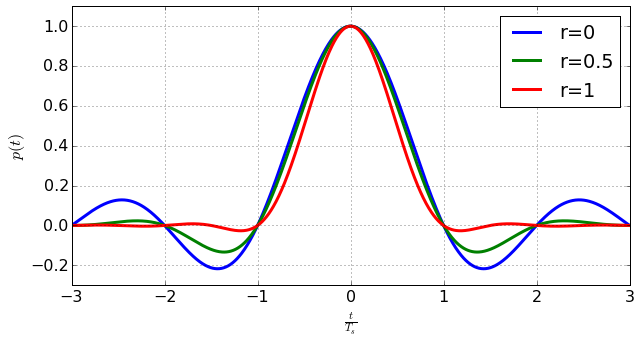

In [3]:
def raised_cosine_pulse(t, Ts, r=1):
    rc = np.zeros(len(t))
    for idx in range(0,len(t)):
        if abs((1-(2*r*t[idx]/Ts)**2)) < 1e-12:
            rc[idx] = (np.sin(pi*t[idx]/Ts)/pi/t[idx]*Ts)*pi/4;
        else:
            rc[idx] = np.sinc(t[idx]/Ts)*np.cos(r*pi*t[idx]/Ts)/(1-(2*r*t[idx]/Ts)**2)
    return rc 

Tb = 10**4
Ts=Tb
num_samples = 1001

t_max = 3*Ts
delta_t = 2*t_max/num_samples
t = np.arange(-t_max, t_max, delta_t)

r_vec = [0, 0.5, 1]
[plt.plot(t/Ts, raised_cosine_pulse(t, Ts, r)) for r in r_vec]
plt.xlabel(r'$\frac{t}{T_s}$')
plt.ylabel(r'$p(t)$')
plt.ylim((-0.3, 1.1))
plt.grid()
plt.legend(labels=["r={}".format(r) for r in r_vec])
plt.show()

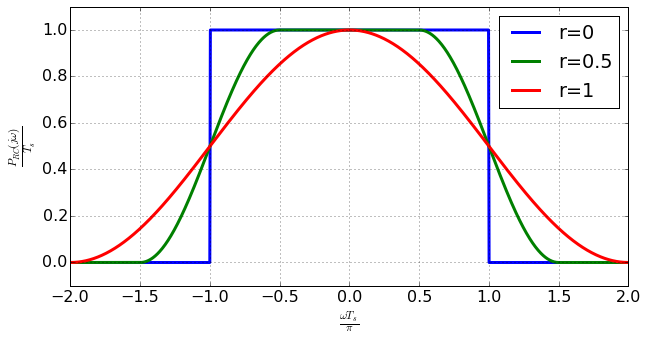

In [4]:
def raised_cosine_ft(omega, Ts, r=1):
    rc = np.zeros((len(omega,)))
    for idx in range(0,len(omega)):
        if np.absolute(omega[idx]) <= (1-r)*pi/Ts:
            rc[idx] = Ts
        elif np.absolute(omega[idx]) <= (1+r)*pi/Ts:
            rc[idx] = Ts/2*(1-np.sin(Ts/(2*r)*(np.absolute(omega[idx])-pi/Ts)))
    return rc

omega_max = 2*pi/Ts
delta_omega = 2*omega_max/num_samples
omega = np.arange(-omega_max, omega_max, delta_omega)

[plt.plot(omega*Ts/pi, raised_cosine_ft(omega, Ts, r)/Ts) for r in r_vec]
plt.xlabel(r'$\frac{\omega T_s}{\pi}$')
plt.ylabel(r'$\frac{P_{RC}(j\omega)}{T_s}$')
plt.ylim((-0.1, 1.1))
plt.grid()
plt.legend(labels=["r={}".format(r) for r in r_vec])
plt.show()

### Root-Raised-Cosine
\begin{align}
P_\text{RRC}(j\omega)=\sqrt{P_{\text{RC}}(j\omega)}
\end{align}

### Excessbandbreite 100% (r=1)
\begin{align}
G(j\omega)&=
\begin{cases}
\sqrt{\frac{T_s}{2}\left(1-\sin\left(\frac{T_s}{2}\left(\left|\omega\right|-\frac{\pi}{T_s}\right)\right)\right)} &:\left|\omega\right|\leq\frac{2\pi}{T_s}\\
0 &: \left|\omega\right|>\frac{2\pi}{T_s}
\end{cases} \\
&=
\begin{cases}
\sqrt{\frac{T_s}{2}\left(1+\cos\left(\frac{T_s}{2}\left|\omega\right|\right)\right)} &:\left|\omega\right|\leq\frac{2\pi}{T_s}\\
0 &: \left|\omega\right|>\frac{2\pi}{T_s}
\end{cases}
\end{align}


## 1.1
Geben Sie die Übertragungsfunktion $F(j\omega)$ eines bezüglich der Signal-zu-Rauschleistung (SNR) optimalen Empfangsfilters an.

### Matched Filter
\begin{align}
f(t) &= h^*(-t) = g(-t)*b(-t) = g(-t)*\delta(-t) = g(-t)\\
F(j\omega) &= G^*(j\omega) = G(j\omega) = P_\text{RRC}(j\omega)
\end{align}

## 1.2
Skizzieren Sie das Augendiagramm hinter dem Empfangsfilter bei ungestörtem Empfang. Erfüllt der Puls das 1. Nyquistkriterium?

\begin{align}
P(j\omega) &= G(j\omega)B(j\omega)F(j\omega) = G(j\omega)F(j\omega) = P_\text{RC}(j\omega) \\
\\
p(t) &= g(t)*b(t)*f(t) = g(t)*f(t) = p_\text{RC}(t)
\end{align}

### Augendiagramm

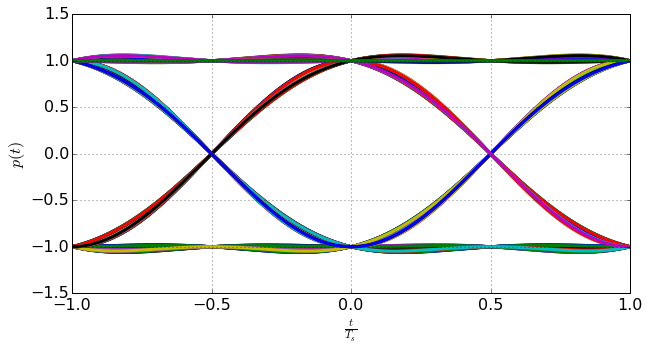

In [5]:
context_bits = 3
pattern_len = 2*context_bits + 1
num_patterns = 2**pattern_len
time_shift = np.arange(-context_bits, context_bits+1)

t_max = Ts
delta_t = 2*t_max/num_samples
t = np.arange(-t_max, t_max, delta_t)

for idx in range(0, num_patterns):
    pattern = np.binary_repr(idx, width=pattern_len)
    
    sig = np.zeros(len(t))
    for idx in range(0, pattern_len):
        offset = time_shift[idx]*Ts
        symbol = 2*int(pattern[idx])-1
        sig += symbol*raised_cosine_pulse(t-offset, Ts, 1)
        
    plt.plot(t/Ts, sig)

plt.xlabel(r'$\frac{t}{T_s}$')
plt.ylabel(r'$p(t)$')
plt.grid()

### 1. Nyquistkrit.
Puls erfüllt 1. Nyquistkrit., da
\begin{align}
p(t)\big|_{t=kT_s} = K\gamma(k)
\end{align}
bzw.
\begin{align}
P(e^{j\omega T_s}) = \frac{1}{T_s}\sum_{n=-\infty}^\infty P\left(j\left(\omega+\frac{2\pi}{T_s}n\right)\right) = \text{const.}
\end{align}

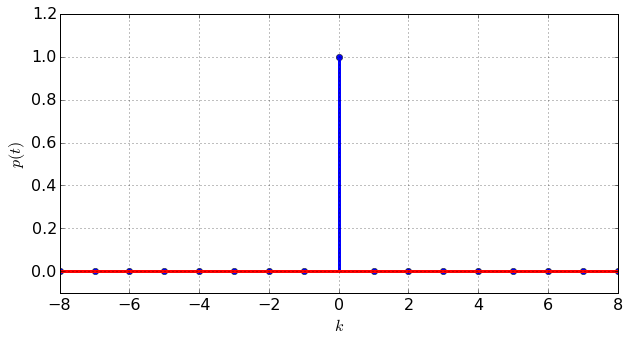

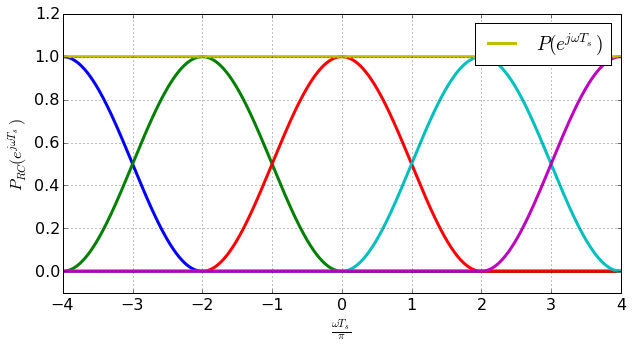

In [6]:
# time domain
kmax = 8
sample_range = np.arange(-kmax, kmax + 1)
pulse_sampled = raised_cosine_pulse(sample_range*Ts, Ts)
plt.stem(sample_range, pulse_sampled)
plt.xlabel(r'$k$')
plt.ylabel(r'$p(t)$')
plt.ylim((-0.1, 1.2))
plt.grid()
plt.show()

# DTFT
nmax = 2
omega_max = nmax*omega_max
omega = np.arange(-omega_max, omega_max, delta_omega)
P_dtft = np.zeros(len(omega))
shift = 2*pi/Ts
for n in range(-nmax, nmax+1):
    summand = raised_cosine_ft(omega - n*shift, Ts)/Ts
    plt.plot(omega*Ts/pi, summand)
    P_dtft += summand
    
handler = plt.plot(omega*Ts/pi, P_dtft)
plt.legend(handler, [r'$P(e^{j\omega T_s})$'])
plt.xlabel(r'$\frac{\omega T_s}{\pi}$')
plt.ylabel(r'$P_{RC}(e^{j\omega T_s})$')
plt.xlim((-2*nmax, 2*nmax))
plt.ylim((-0.1, 1.2))
plt.grid()
plt.show()

## 1.3
Bestimmen Sie das Leistungsdichtespektrum $\Phi_{ss}(j\omega)$ des Sendesignals $s(t)$. Wieviel Bandbreite belegt das Sendesignal? Welche Bandbreiteneffizienz wird erzielt?

\begin{align}
\Phi_{ss}(j\omega) &= \frac{1}{T_s}\left|G(j\omega)\right|^2 \Phi_{AA}(e^{j\omega T_s}) = \frac{1}{T_s} P_\text{RC}(j\omega)\\
\Rightarrow B &= \frac{1}{2}(1+r)\frac{1}{T_s} = \frac{1}{T_s}\\
\Rightarrow \nu_\text{RC} &= \frac{f_\text{bit}}{B} = \frac{f_\text{bit}}{f_\text{sym}}\frac{f_\text{sym}}{B} = \log_2\left|\Omega_A\right|\frac{2}{1+r} = 1
\end{align}

## 1.4
Bestimmen Sie das Leistungsdichtespektrum $\Phi_{n'n'}(j\omega)$ und die Autokorrelationsfunktion $\varphi_{n'n'}(\tau)$ des Rauschens hinter dem Empfangsfilter. Ist das Rauschen weiß?

\begin{align}
\Phi_{n'n'}(j\omega) &= \left|F(j\omega)\right|^2 \Phi_{nn}(j\omega) = \frac{N_0}{2} P_\text{RC}(j\omega)\\
\Rightarrow \varphi_{n'n'}(\tau) &= \frac{N_0}{2} p_\text{RC}(t)
\end{align}

Das Rauschen ist nicht weiß, da LDS nicht konstant.

## 1.5
Bestimmen Sie das Leistungsdichtespektrum $\Phi_{n'n'}(e^{j\omega T_s})$ und die Autokorrelationsfunktion $\varphi_{n'n'}(\lambda)$ des Rauschens hinter dem Abtaster. Ist das Rauschen weiß?

\begin{align}
\Phi_{n'n'}(e^{j\omega T_s}) &= \frac{N_0}{2} P_\text{RC}(e^{j\omega T_s}) = \frac{N_0}{2} \\
\Rightarrow \varphi_{n'n'}(\lambda) &= \frac{N_0}{2}\gamma(k)
\end{align}

Das Rauschen ist weiß, da LDS konstant.

## 1.6
Berechnen Sie das Signal-zu-Rauschleistungsverhältnis (SNR) der Entscheidungsvariable $q(k)$ bei optimaler Abtastung in dB.

\begin{align}
\mathrm{SNR} 
&= \frac{S}{N} = \frac{1}{\frac{N_0}{2}}\\
&= \frac{1}{10^{-6}} = 10^6\\
\mathrm{SNR}\big|_\mathrm{dB} 
&= 60\mathrm{dB}
\end{align}

## 1.7
Bestimmen Sie die Bitfehlerwahrscheinlichkeit.

\begin{align}
P_b &= \frac{1}{2}Q\left(\sqrt{\frac{E_s}{\frac{N_0}{2}}}\right) + \frac{1}{2}Q\left(\sqrt{\frac{E_s}{\frac{N_0}{2}}}\right) = Q\left(\sqrt{\frac{E_s}{\frac{N_0}{2}}}\right) = Q\left(\sqrt{\frac{1}{10^{-6}}}\right) = Q\left(10^3\right)
\end{align}

/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


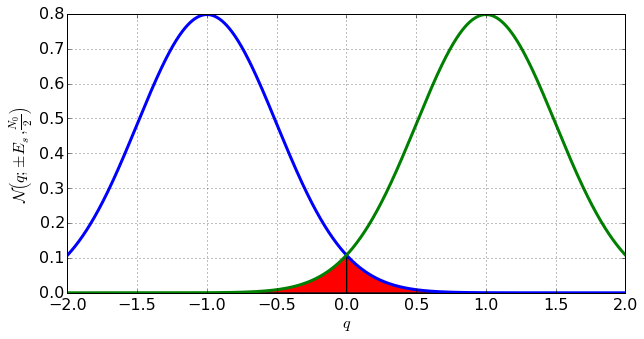

In [7]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))/np.sqrt(2*pi*np.power(sig, 2.))

A = [-1, 1]
q_max = 2
delta_q = q_max/num_samples
q = np.arange(-q_max, q_max, delta_q)
Es = 1
N0 = 1
fig, ax = plt.subplots()
for sym in A:
    pdf = gaussian(q, sym*Es, N0/2)
    ax.plot(q, pdf)
    if sym > 0:
        idx_fill = [idx for idx in range(0, len(q)) if q[idx] < 0]
    else:
        idx_fill = [idx for idx in range(0, len(q)) if q[idx] > 0]
    q_fill = q[idx_fill]
    pdf_fill = pdf[idx_fill]
    ax.fill_between(q_fill, pdf_fill, 0, facecolor='r')

plt.ylabel(r'$\mathcal{N}\left(q;\pm E_s,\frac{N_0}{2}\right)$')
plt.xlabel(r'$q$')
plt.grid()
plt.show()

## 1.8
Überprüfen Sie für die folgenden Kanalimpulsantworten, ob die 1. Nyquist-Bedingung erfüllt wird (falls nicht berechnen Sie die Leistung der Intersymbolinterferenzen).

1. $b(t)= a\cdot\ \delta(t-\tau); a\in\mathbb{R} \backslash \{0\}; \tau>0$

2. $b(t)= \delta(t) - a\delta(t-T_s); a\in\mathbb{R} \backslash \{0\}$

### 1.8.1


In [0]:
a=0.5
tau = Ts/3
kmax = 8
sample_range = np.arange(-kmax, kmax + 1)

In [0]:
pulse_sampled = a*raised_cosine_pulse(sample_range*Ts - tau, Ts)
plt.stem(sample_range, pulse_sampled)
plt.xlabel(r'$k$')
plt.ylabel(r'$p(t)$')
plt.ylim((-0.1, a))
plt.grid()
plt.show()

1. Nyquistkrit. nicht erfüllt $\Rightarrow$ ISI

### 1.8.2

In [0]:
pulse_sampled = raised_cosine_pulse(sample_range*Ts, Ts) - a*raised_cosine_pulse(np.arange(-kmax, kmax + 1)*Ts - Ts, Ts)
plt.stem(sample_range, pulse_sampled)
plt.xlabel(r'$k$')
plt.ylabel(r'$p(t)$')
plt.ylim((-1.2*a, 1.2))
plt.grid()
plt.show()

1. Nyquistkrit. nicht erfüllt $\Rightarrow$ ISI